In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0003559,ISIC_0025810,bkl,consensus,75.0,male,face
1,HAM_0004240,ISIC_0032517,mel,histo,50.0,male,back
2,HAM_0002610,ISIC_0026876,vasc,consensus,0.0,female,abdomen
3,HAM_0003229,ISIC_0031140,bcc,histo,60.0,male,chest
4,HAM_0005963,ISIC_0028129,nv,follow_up,45.0,male,foot


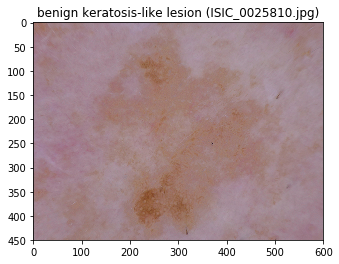

In [2]:
metadata_path = './skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
metadat = pd.read_csv(metadata_path)
num_samples = len(metadat)
metadat = metadat.sample(frac=1,random_state=12).reset_index(drop=True) #shuffling data

tmp = plt.imread('./train/bkl/ISIC_0025810.jpg')
plt.imshow(tmp)
plt.title('benign keratosis-like lesion (ISIC_0025810.jpg)')
metadat.head()

In [4]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

img_width, img_height = 299, 299
train_data_dir = "./train"
validation_data_dir = "./val"
nb_train_samples = 6409
nb_validation_samples = 1602 
batch_size = 64
epochs = 5

model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))


# Freeze the layers which you don't want to train. Here I am freezing the all layers.
for layer in model.layers:
    layer.trainable = False

#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(7, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

# Initiate the train and test generators with data Augumentation 
ntrain2 = int(len(metadat)*0.8)
ntrain1 = int(ntrain2*0.8)
x_test = metadat.iloc[ntrain2:,:]
x_train = metadat.iloc[:ntrain1,:]
x_val = metadat.iloc[ntrain1:ntrain2,:]

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

val_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        './train',
        target_size=(299, 299),
        batch_size=64,
        seed=12)

validation_generator = val_datagen.flow_from_directory(
        './val',
        target_size=(299, 299),
        batch_size=64,
        seed=12)

test_generator = test_datagen.flow_from_directory(
        './test',
        target_size=(299, 299),
        batch_size=64,
        seed=12)

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vgg16_10.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


# Train the model 
history = model_final.fit_generator(
train_generator,
steps_per_epoch = nb_train_samples//batch_size,
epochs = epochs,
validation_data = validation_generator,
validation_steps = nb_validation_samples//batch_size,
callbacks = [checkpoint])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 6408 images belonging to 7 classes.
Found 1602 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.
Epoch 1/5
100/100 [==============================] - 356s 4s/step - loss: 1.1950 - acc: 0.6587 - val_loss: 1.1228 - val_acc: 0.6569

Epoch 00001: val_acc improved from -inf to 0.65687, saving model to vgg16_10.h5
Epoch 2/5
100/100 [==============================] - 345s 3s/step - loss: 1.0985 - acc: 0.6753 - val_loss: 1.0820 - val_acc: 0.6569

Epoch 00002: val_acc did not improve from 0.65687
Epoch 3/5
100/100 [==============================] - 315s 3s/step - loss: 1.0803 - acc: 0.6761 - val_loss: 1.0593 - val_acc: 0.6594

Epoch 00003: val_acc improved from 0.65687 to 0.65938, saving model to vgg16_10.h5
Epoch 4/5
100/100 [==============================] - 331s 3s/step - loss: 1.0756 - acc: 0.6722 - val_loss: 1.0458 - val_acc: 0.6581

Epoch 00004: val_acc did not improve from 0.65938
Epoch 5/5
100/100 [==============================] - 356s 4s/step - loss: 1.054

In [ ]:
model_final.save('./models/vgg_epoch10.h5')

Normalized confusion matrix
[[0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.03 0.97 0.  ]
 [0.   0.   0.   0.   0.02 0.98 0.  ]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.02 0.98 0.  ]
 [0.   0.   0.   0.   0.03 0.97 0.  ]
 [0.   0.   0.   0.   0.09 0.91 0.  ]]


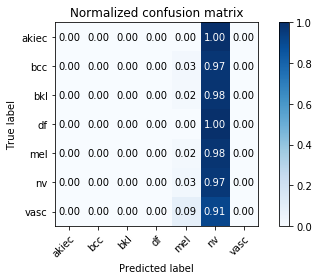

In [5]:
y_pred = model_final.predict_generator(validation_generator)

y_val = np.ndarray(shape=((len(validation_generator)-1)*64, 7),dtype=int)
for i in range(len(validation_generator)-1):
    y_val[i*64:(i+1)*64][:] = validation_generator[i][1]

# make confusion matrix
lab = np.argmax(y_val,axis=1)
pred = np.argmax(y_pred,axis=1)
cm = np.zeros((7,7))
for i in range(len(lab)):
    cm[lab[i]][pred[i]] += 1

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

#     # Compute confusion matrix
#     cm = confusion_matrix(y_true, y_pred)
#     # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = np.array(['akiec','bcc','bkl','df','mel','nv','vasc'])
np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plot_confusion_matrix(cm, classes=class_names,
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('vgg_epoch10_conf_mat.png')
plt.show()

In [ ]:
from keras.metrics import binary_accuracy
y_pred = model.predict_generator(validation_generator)
y_pred = np.argmax(y_pred,axis=0)
count = 0
correct = 0
for i in range(len(validation_generator)):
    if np.argmax(validation_generator[i][1]) == y_pred[i]:
        correct +=1
    count+=1
    print(str(acc))